# Project No. 3: Average Temperatures 1995-2019

This exploratory analysis looks at global temperatures between 1995 and 2019 and explores Europe and Austria in more detail.

Data from: https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities

## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from tqdm import tqdm_notebook as tqdm
import datetime
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [44]:
df = pd.read_csv("city_temperature.csv", low_memory = False)

## Memory usage

Having a first look at the dataframe, I see that there's information about the region, country, state (in case of the US), city, date and average temperatuer (in Fahrenheit). 

In [3]:
df.sample(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
1541906,North America,US,Arizona,Yuma,11,1,2005,-99.0
2267222,North America,US,New Mexico,Albuquerque,6,16,2004,80.3
997215,Europe,Yugoslavia,NaN,Belgrade,1,19,1998,40.6
2568629,North America,US,South Carolina,Columbia,3,15,2002,65.5
2310292,North America,US,New York,Syracuse,7,19,1995,71.6


I noticed that my computer takes quite a while to process the dataframe,so I have a look at its memory usage.

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 767.7 MB


In [5]:
df.memory_usage(deep=True)

Index                   128
Region            200858229
Country           179884611
State             141323998
City              189912136
Month              23250616
Day                23250616
Year               23250616
AvgTemperature     23250616
dtype: int64

Since the dataframe takes 767.7 MB and has almost 3 million rows, I decide to decrease its memory usage in order to be able to work with it a little bit faster.

First, I convert the data type of some of the columns. Month and Day are converted from int64 to int 8 (as they only take on a max. value of 12 and 31, respectively), Year is converted from int64 to int16 (only takes on a max. values of 2020), and AvgTemperature is converted from float64 to float16.

In [45]:
df[['Month', 'Day']] = df[['Month', 'Day']].astype('int8')
df[['Year']] = df[['Year']].astype('int16')
df['AvgTemperature'] = df['AvgTemperature'].astype('float16')

In [46]:
df.reset_index(drop=True, inplace=True)

In [28]:
df.sample(5)

,Region,Country,State,City,Month,Day,Year,AvgTemperature
2894214,North America,US,Wyoming,Cheyenne,10,14,2005,56.68750
796444,Europe,Italy,NaN,Milan,5,13,2000,64.18750
1884335,North America,US,Indiana,Fort Wayne,1,21,2012,17.50000
785011,Europe,Iceland,NaN,Reykjavik,10,19,2019,40.90625
1562551,North America,US,California,Fresno,8,20,1999,79.37500


In [9]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int8   
 5   Day             int8   
 6   Year            int16  
 7   AvgTemperature  float16
dtypes: float16(1), int16(1), int8(2), object(4)
memory usage: 695.6 MB


In [10]:
df.memory_usage(deep=True)

Index                   128
Region            200858229
Country           179884611
State             141323998
City              189912136
Month               2906327
Day                 2906327
Year                5812654
AvgTemperature      5812654
dtype: int64

## Data cleaning


First of all, there are some ambiguous year values in the dataframe, so I drop them. I also drop all data from the year 2020, since there is no data available for the whole year yet.

In [47]:
df = df[df.Year!=200]
df = df[df.Year!=201]
df = df[df.Year!=2020]

I also drop the column State, since it only applies to the US, which I don't want to analyze in detail.

In [48]:
df = df.drop('State', axis=1)

Next, I create a separate datetime column. However, I leave out the Day column since I do not need to work with daily temperatures. Monthly temperatures are fine and will save me some computational cost with certain plots.

In [49]:
df['Date'] = pd.to_datetime(df.Year.astype(str) + '/' + df.Month.astype(str))

To handle any missing data, I first look at what percentage of data is missing for each country.

In [50]:
missing = pd.DataFrame(df.loc[df.AvgTemperature == -99, 'Country'].value_counts())
missing['TotalData'] = df.groupby('Country').AvgTemperature.count()
missing['PercentageMissing'] = missing.apply(lambda row: (row.Country/row.TotalData)*100, axis=1)
missing.sort_values(by=['PercentageMissing'], inplace=True, ascending=False)
missing.head(10)

,Country,TotalData,PercentageMissing
Burundi,3659,4543,80.541492
Guyana,2929,5065,57.828233
Malawi,3052,5693,53.609696
Sierra Leone,3145,6209,50.652279
Guinea-Bissau,4083,9133,44.706011
Bangladesh,2243,5810,38.605852
Haiti,3451,9135,37.777778
Oman,2993,8917,33.565100
Germany,6977,24384,28.613025
Kenya,2139,8037,26.614408


It looks like there is a lot of data missing in Burundi, as well as in some other African, Latin American, Asian and European countries.

Since any missing temperatures are saved as -99, I convert them to NaN.

In [51]:
df.loc[df.AvgTemperature == -99, 'AvgTemperature'] = np.nan

In [52]:
print(df.AvgTemperature.isna().sum())

79164


I then fill the missing values with the mean temperature of the same city and of the same date every year.

In [53]:
df['AvgTemperature'] = df['AvgTemperature'].fillna(df.groupby(['City', 'Date']).AvgTemperature.transform('mean'))

In [54]:
print(df.AvgTemperature.isna().sum())

25627


However, it seems that for some cities, there is so much data missing, that they may not be any recorded temperature for a given date.

In [55]:
print(df.loc[df.AvgTemperature.isna(), 'City'].value_counts()[:10])

Bissau            3014
Bujumbura         2401
Muscat            2285
Freetown          2159
Lilongwe          1709
Georgetown        1397
Tirana            1127
Port au Prince    1034
Nicosia            853
Nairobi            760
Name: City, dtype: int64


So for those cities, I fill the missing data with the overall mean temperature of the city

In [56]:
df['AvgTemperature'] = df['AvgTemperature'].fillna(df.groupby(['City']).AvgTemperature.transform('mean'))

In [57]:
print(df.AvgTemperature.isna().sum())

0


Since I have a better intuition for temperatures in Celsius, I convert them.

In [66]:
# °F to °C: (°F − 32) × 5/9 = °C
df['AvgTempCelsius'] = (df.AvgTemperature -32)*(5/9)
df = df.drop("AvgTemperature", axis=1)

Finally, I round the temperatures in tow different way, once with two and once with one decimal.

In [60]:
df['AvgTempCelsius_rounded'] = df.AvgTempCelsius.apply(lambda x: "{0:0.2f}".format(x))
df['AvgTempCelsius_rounded2'] = df.AvgTempCelsius.apply(lambda x: "{0:0.1f}".format(x))

In [61]:
df['AvgTempCelsius_rounded'] = pd.to_numeric(df['AvgTempCelsius_rounded'])
df['AvgTempCelsius_rounded2'] = pd.to_numeric(df['AvgTempCelsius_rounded2'])

In [67]:
df.sample(5)

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2
2232073,North America,US,Las Vegas,9,9,2009,2009-09-01,31.046875,31.05,31.0
121987,Africa,Morocco,Rabat,12,17,2016,2016-12-01,10.281250,10.28,10.3
853785,Europe,Poland,Warsaw,2,10,2004,2004-02-01,-1.997070,-2.00,-2.0
2244820,North America,US,Concord,3,23,2019,2019-03-01,2.275391,2.28,2.3
1261836,South/Central America & Carribean,Belize,Belize City,10,18,2011,2011-10-01,28.062500,28.06,28.1


Finally, I save the dataframe as a pickle in order to reload it quickly next time I want to work with it.

In [68]:
df.to_pickle('temperature_rise_ready.pkl')

## Analysis

### Global

In [69]:
df = pd.read_pickle('temperature_rise_ready.pkl')

In [70]:
df.sample(5)

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2
2218273,North America,US,Reno,4,10,1997,1997-04-01,3.333984,3.33,3.3
57220,Africa,Ethiopia,Addis Ababa,5,19,2012,2012-05-01,20.656250,20.66,20.7
54242,Africa,Ethiopia,Addis Ababa,3,24,2004,2004-03-01,17.265625,17.27,17.3
1103786,Middle East,Turkey,Istanbul,1,8,1999,1999-01-01,8.562500,8.56,8.6
1094174,Middle East,Turkey,Ankara,1,27,1998,1998-01-01,-0.052094,-0.05,-0.1


#### YEARLY GLOBAL AVERAGE TEMPERATURE OVER TIME

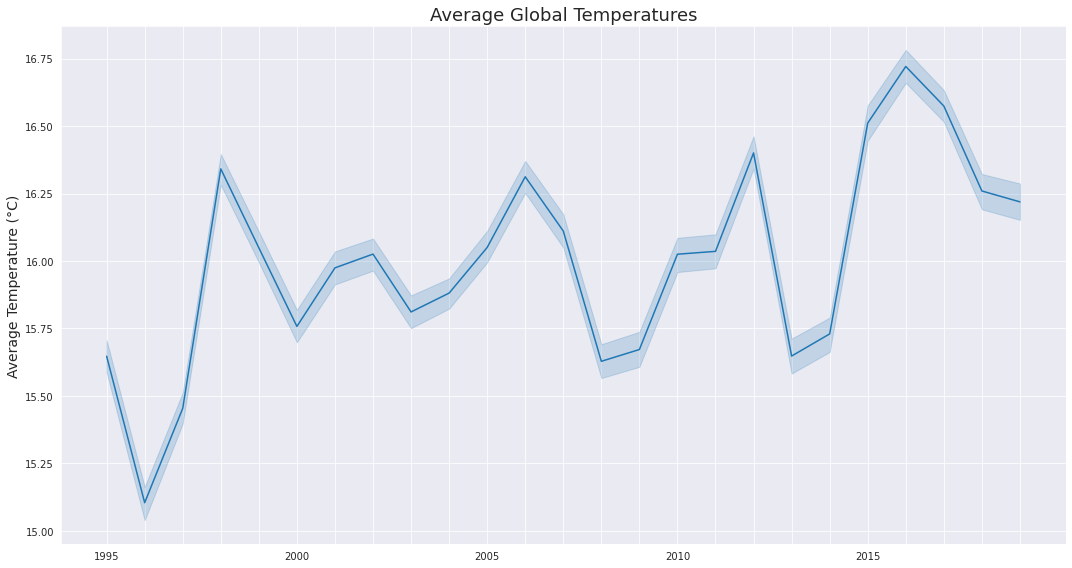

In [180]:
#fig, ax = plt.figure()
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(x='Year', y='AvgTempCelsius', data=df , palette='Set2')
ax.set_title('Average Global Temperatures', fontsize=18)
ax.set_ylabel('Average Temperature (°C)', fontsize=14)
ax.set_xlabel('')
ax.set_xticks(range(1995, 2020))
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)
plt.tight_layout()
plt.show();

#### MONTHLY GLOBAL AVERAGE TEMPERATURE OVER TIME

In [83]:
df_mean_month = df.groupby(['Month', 'Year']).AvgTempCelsius_rounded2.mean()
df_mean_month = df_mean_month.reset_index()
df_mean_month = df_mean_month.sort_values(by=['Year'])

In [84]:
df_pivoted = pd.pivot_table(
    data=df_mean_month,
    index='Month',
    values='AvgTempCelsius_rounded2',
    columns='Year'
)

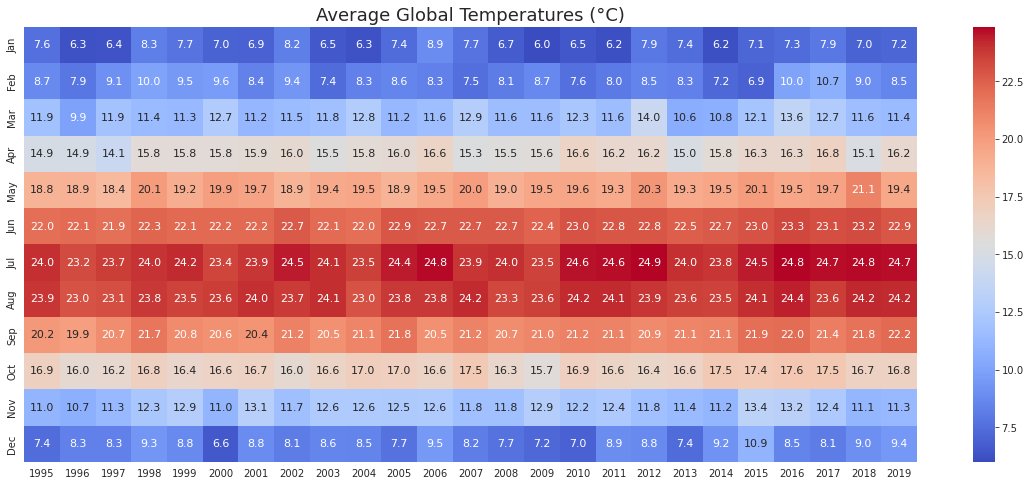

In [174]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(data = df_pivoted, cmap='coolwarm', annot=True, fmt=".1f", annot_kws={'size':11})
plt.xlabel('')
plt.ylabel('')
ax.set_yticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title('Average Global Temperatures (°C)', fontsize=18)
plt.show();

#### AVERAGE TEMPERATURE OF DIFFERENT REGIONS

In [89]:
s = df.groupby(['Region'])['AvgTempCelsius'].mean().reset_index().sort_values(by='AvgTempCelsius', ascending=False)
s.style.background_gradient(cmap="RdBu_r")

,Region,AvgTempCelsius
0,Africa,23.656250
4,Middle East,23.453125
6,South/Central America & Carribean,22.578125
1,Asia,20.234375
2,Australia/South Pacific,16.796875
5,North America,13.507812
3,Europe,11.195312


#### AVERAGE TEMPERATURE OF DIFFERENT REGIONS OVER TIME

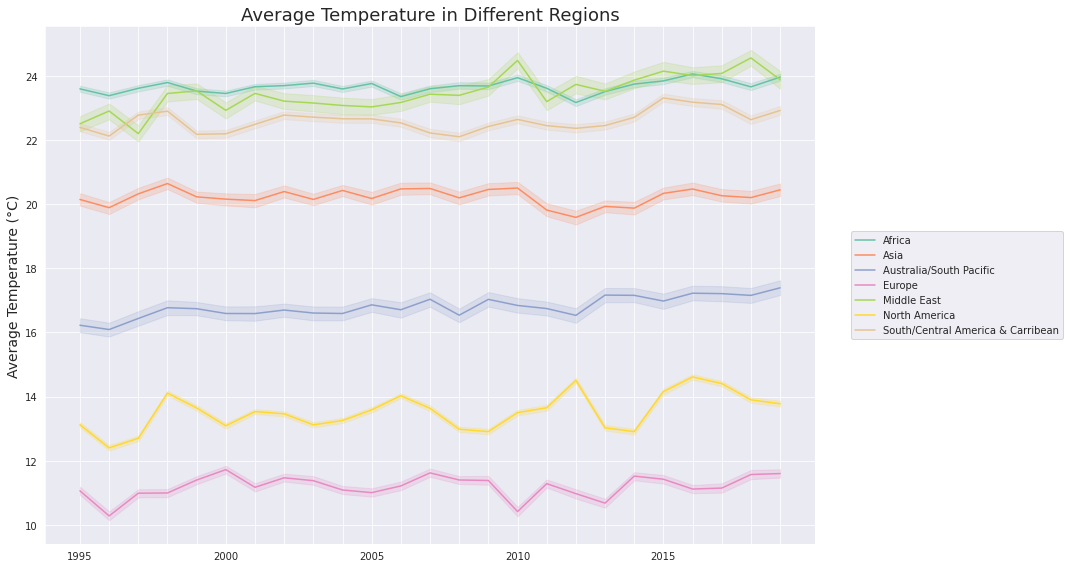

In [179]:
f, ax = plt.subplots(figsize=(15,8))
sns.lineplot(x='Year', y='AvgTempCelsius', hue='Region', data=df , palette='Set2')
plt.title('Average Temperature in Different Regions', fontsize=18)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.xlabel('')
plt.xticks(range(1995, 2020))
plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), ncol=1)
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)
plt.tight_layout()
plt.show();

#### DISTRIBUTION OF TEMPERATURES IN DIFFERENT REGIONS

In [94]:
continents_avg_temp_month = df.groupby(['Region', 'Date'])['AvgTempCelsius'].mean().reset_index()

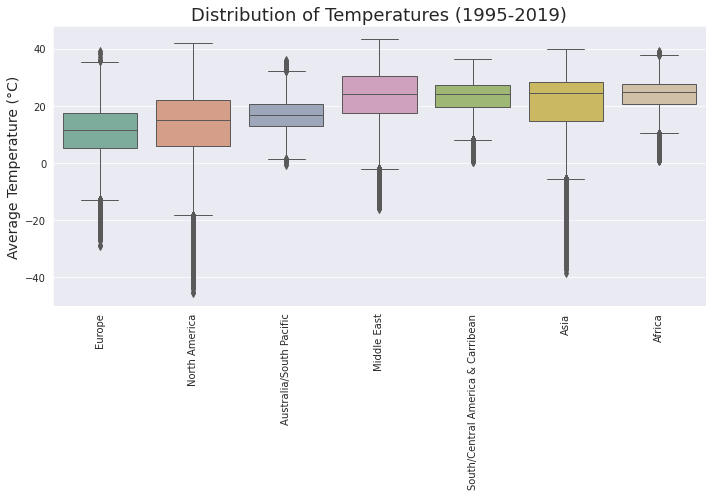

In [102]:
region_sorted = df.groupby('Region')['AvgTempCelsius'].median().sort_values().index

with sns.color_palette("Set2"):
    f, ax = plt.subplots(figsize=(10, 7))
    sns.boxplot(data=df.sort_values("AvgTempCelsius"), x='Region', y='AvgTempCelsius', order=region_sorted, saturation=0.5, linewidth=1)
    plt.xticks(rotation=90)
    plt.title('Distribution of Temperatures (1995-2019)', fontsize=18)
    plt.xlabel('')
    plt.ylabel('Average Temperature (°C)', fontsize=14)
    plt.tight_layout()
    plt.show();

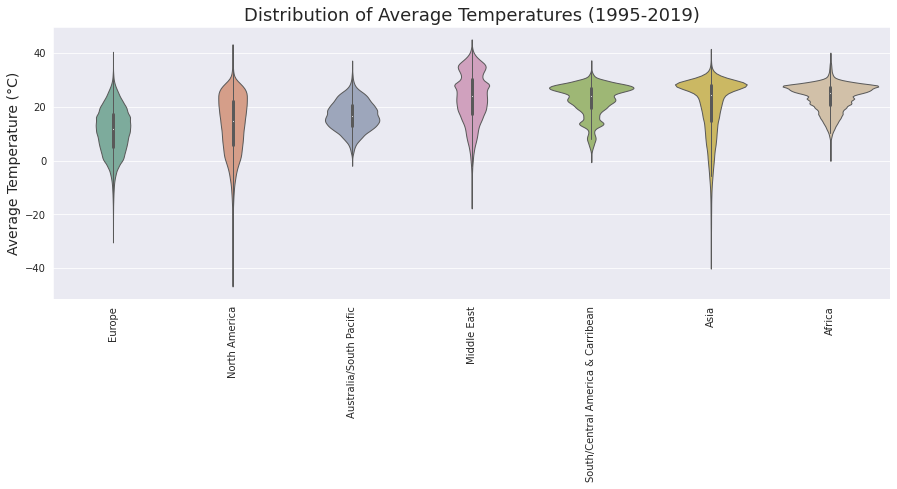

In [105]:
with sns.color_palette("Set2"):
    f, ax = plt.subplots(figsize=(15, 5))
    sns.violinplot(data=df.sort_values("AvgTempCelsius"), x='Region', y='AvgTempCelsius_rounded', order=region_sorted, saturation=0.5, linewidth=1)
    plt.xticks(rotation=90)
    plt.title('Distribution of Average Temperatures (1995-2019)', fontsize=18)
    plt.xlabel('')
    plt.ylabel('Average Temperature (°C)', fontsize=14)
    plt.show()

#### MONTHLY AVERAGE TEMPERATURE IN DIFFERENT REGIONS

In [106]:
regions = df.Region.unique().tolist()

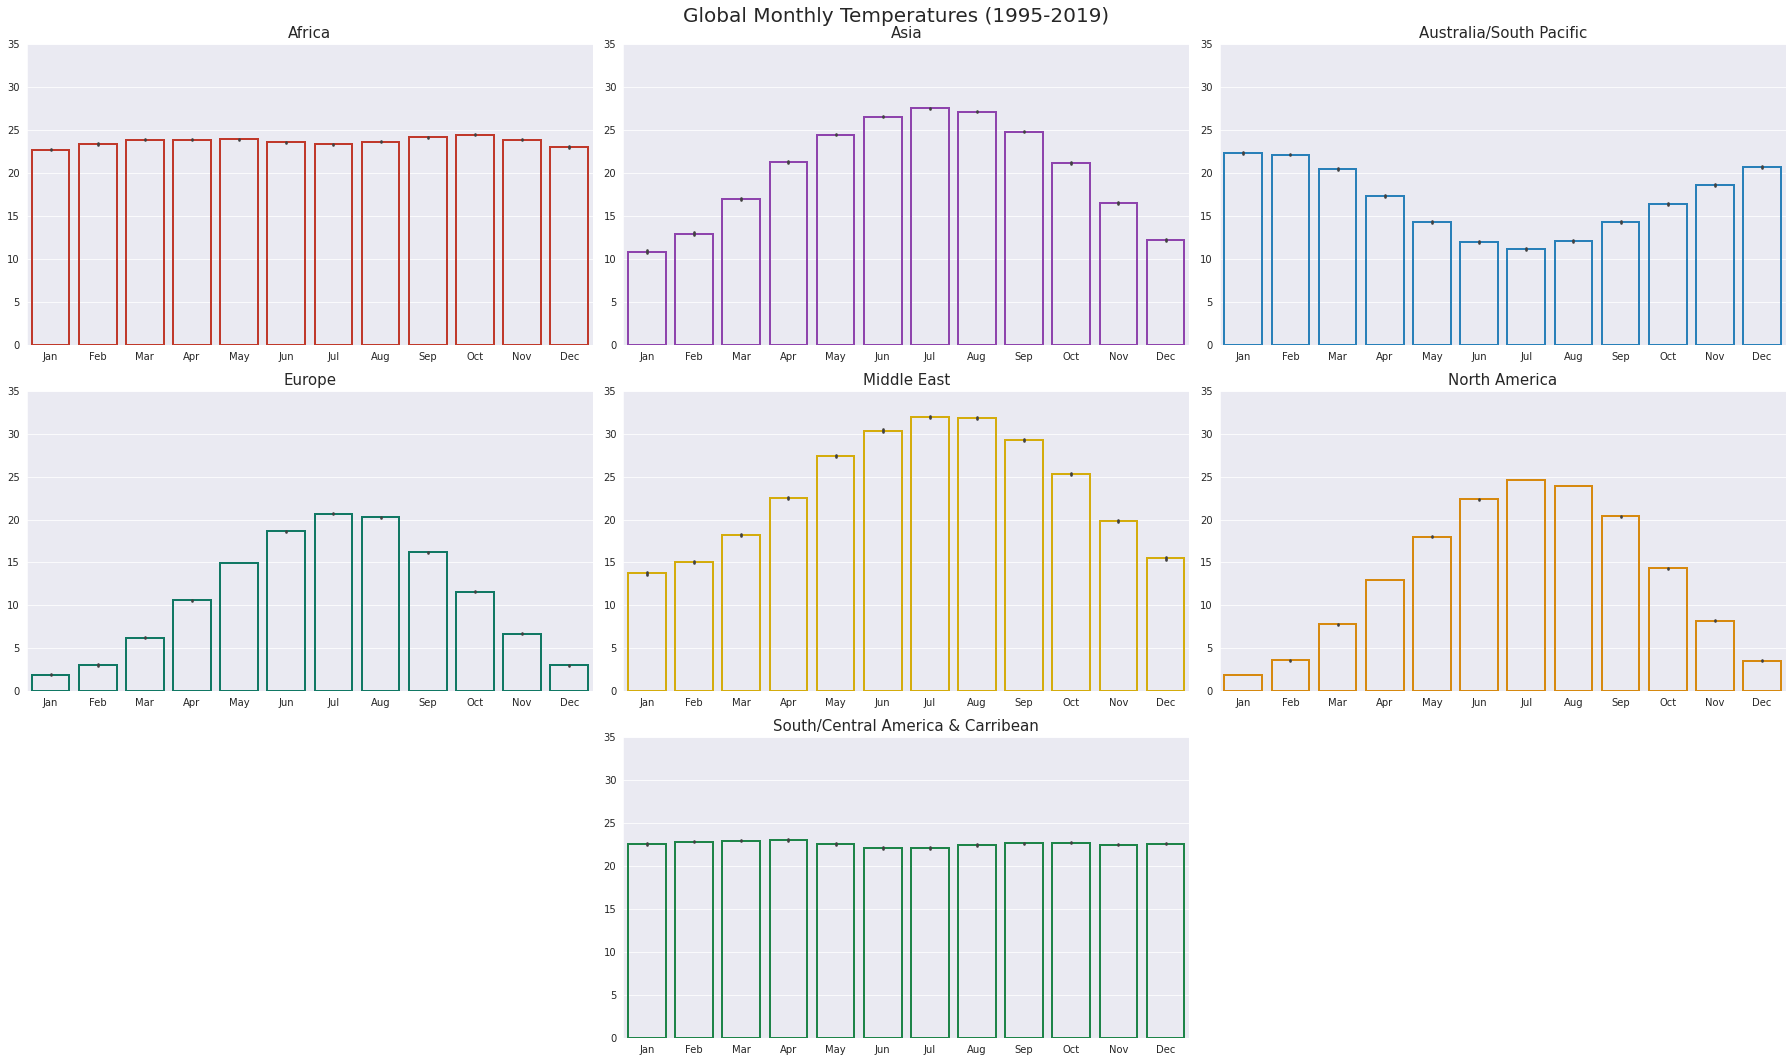

In [123]:
number_plot = [0, 0, 0, 1, 1, 1, 2]
position_a = [0, 2, 4, 0, 2, 4, 2]
position_b = [2, 4, 6, 2, 4, 6, 4]

fig = plt.figure(figsize = (25, 15))
#plt.suptitle('Global Monthly Temperatures (1995-2019)', y=1.05, fontsize=20)
plt.suptitle('Global Monthly Temperatures (1995-2019)', fontsize=20)
gs = gridspec.GridSpec(3, 6)
palette = ["#C0392B", "#8E44AD", "#2980B9", "#117864", "#D4AC0D", "#D68910", "#1E8449"]
for i in range(7): 
    ax = plt.subplot(gs[number_plot[i], position_a[i]:position_b[i]])
    sns.barplot(x='Month', y='AvgTempCelsius_rounded2', data=df[df.Region == regions[i]], facecolor=(0, 0, 0, 0), edgecolor=palette[i], linewidth=2)
    ax.set_title(regions[i], fontsize=15)
    ax.set_ylim((0, 35))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

#### TOP 10 HOTTEST COUNTRIES

In [124]:
s = df.groupby(['Country'])['AvgTempCelsius'].mean().reset_index().sort_values(by='AvgTempCelsius',ascending=False)[:10]
s.style.background_gradient(cmap="Reds")

,Country,AvgTempCelsius
44,Haiti,29.828125
108,Thailand,28.843750
78,Nigeria,28.734375
50,Indonesia,28.593750
117,United Arab Emirates,28.531250
43,Guyana,28.515625
81,Oman,28.453125
88,Qatar,28.390625
42,Guinea-Bissau,28.031250
85,Philippines,27.968750


#### TOP 10 COLDEST COUNTRIES

In [127]:
s = df.groupby(['Country'])['AvgTempCelsius'].mean().reset_index().sort_values(by='AvgTempCelsius',ascending=True)[:10]
s.style.background_gradient(cmap="Blues")

,Country,AvgTempCelsius
70,Mongolia,-0.833984
48,Iceland,5.343750
80,Norway,5.480469
18,Canada,5.875000
33,Finland,5.976562
14,Bolivia,7.488281
62,Latvia,7.492188
102,Sweden,7.605469
9,Belarus,7.652344
90,Russia,7.718750


### Europe

In [128]:
df_europe = df[df.Region == 'Europe'].copy()

In [129]:
df_europe.sample(5)

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2
740088,Europe,Germany,Hamburg,2,11,2000,2000-02-01,5.660156,5.66,5.7
879572,Europe,Russia,Moscow,8,9,1998,1998-08-01,14.828125,14.83,14.8
682182,Europe,Cyprus,Nicosia,10,18,2003,2003-10-01,19.968750,19.97,20.0
822495,Europe,Macedonia,Skopje,8,2,1995,1995-08-01,22.296875,22.30,22.3
795819,Europe,Italy,Milan,8,27,1998,1998-08-01,21.875000,21.88,21.9


#### DISTRIBUTION OF  TEMPERATURES IN EUROPE

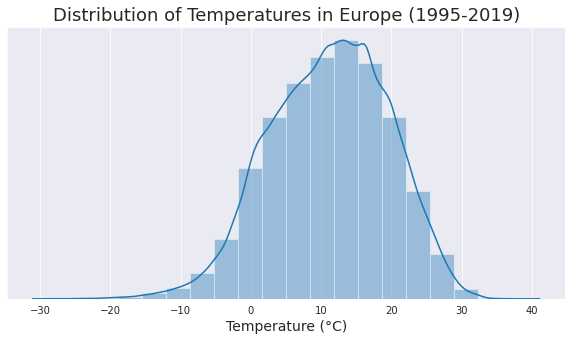

In [131]:
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df_europe.AvgTempCelsius_rounded, bins = 20)
plt.title('Distribution of Temperatures in Europe (1995-2019)', fontsize=18)
plt.xlabel('Temperature (°C)', fontsize=14)
ax.axes.yaxis.set_visible(False)
ax.axes.yaxis.set_ticklabels([''])
plt.show()

#### DISTRIBUTION OF TEMPERATURES IN EUROPE IN 2019

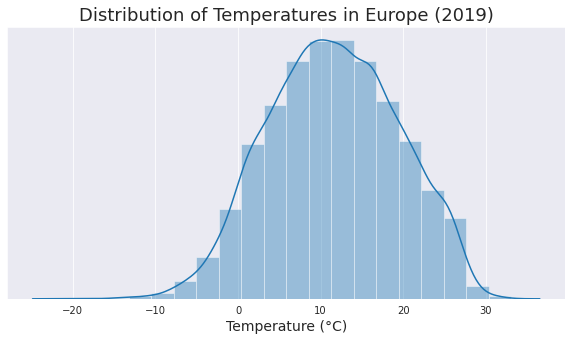

In [138]:
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df_europe[df_europe.Year == 2019].AvgTempCelsius_rounded, bins=20)
plt.title('Distribution of Temperatures in Europe (2019)', fontsize=18)
plt.xlabel('Temperature (°C)', fontsize=14)
ax.axes.yaxis.set_visible(False)
ax.axes.yaxis.set_ticklabels([''])
plt.show()

#### DISTRIBUTION OF TEMPERATURES IN DIFFERENT EUROPEAN COUNTRIES

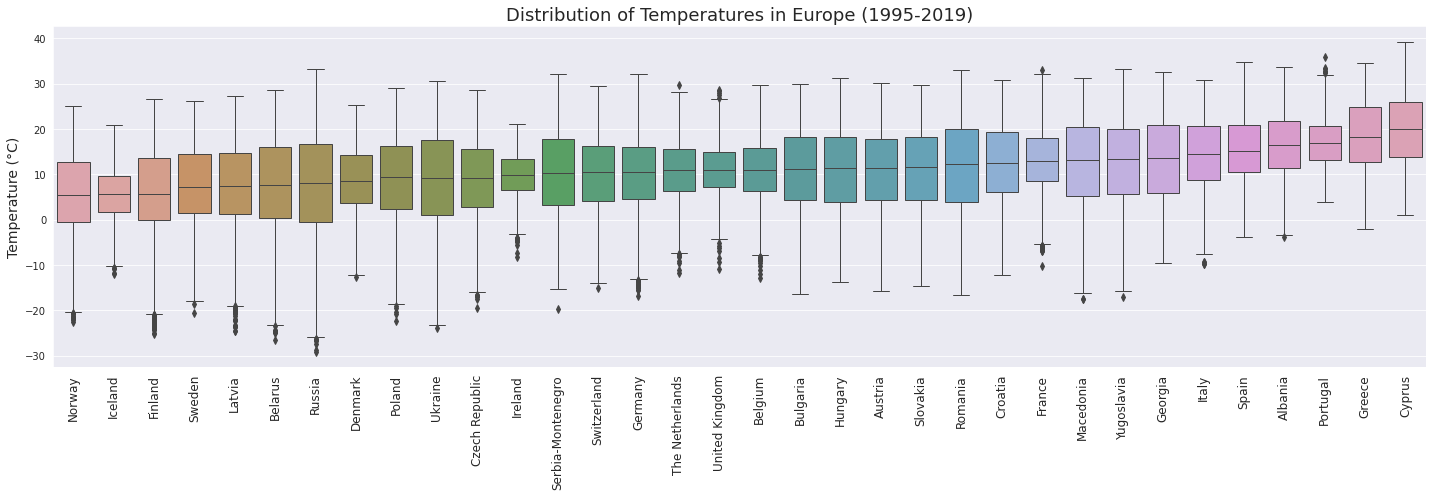

In [140]:
countries_sorted = df_europe.groupby('Country')['AvgTempCelsius_rounded2'].median().sort_values().index

with sns.color_palette("Set2"):
    f, ax = plt.subplots(figsize=(20, 7))
    sns.boxplot(data=df_europe, x='Country', y='AvgTempCelsius_rounded', order=countries_sorted, saturation=0.5, linewidth=1)
    plt.xticks(rotation=90, fontsize=12)
    plt.title('Distribution of Temperatures in Europe (1995-2019)', fontsize=18)
    plt.ylabel('Temperature (°C)', fontsize=14)
    plt.xlabel('')
    plt.tight_layout()
    plt.show()

#### AVERAGE TEMPERATURE IN DIFFERENT EUROPEAN COUNTRIES

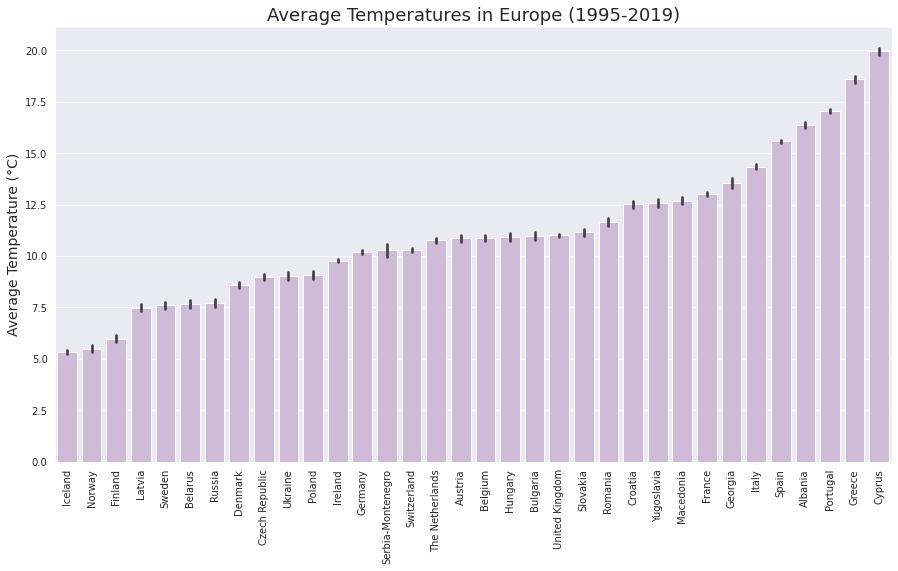

In [147]:
countries_mean_sorted = df_europe.groupby('Country').AvgTempCelsius_rounded2.mean().sort_values().index

plt.figure(figsize=(15,8))
sns.barplot(x='Country', y='AvgTempCelsius_rounded2', data=df_europe, order=countries_mean_sorted, color="#D2B4DE", saturation=0.7)
plt.xticks(rotation=90)
plt.xlabel('')
plt.title('Average Temperatures in Europe (1995-2019)', fontsize=18)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.show()

#### AVERAGE TEMPERATURE IN EUROPE OVER TIME 

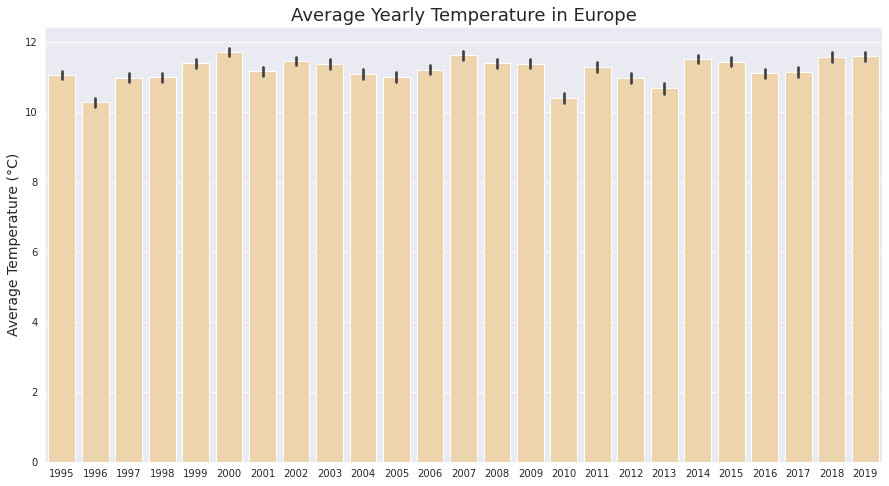

In [178]:
plt.figure(figsize=(15,8))
sns.barplot(x='Year', y='AvgTempCelsius_rounded2', data=df_europe, color="#FAD7A0", saturation=0.7)
plt.title('Average Yearly Temperature in Europe', fontsize=18)
plt.xlabel('')
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.show();

#### MONTHLY AVERAGE TEMPERATURE IN EUROPE OVER TIME

In [149]:
europe_mean_month = df_europe.groupby(['Month', 'Year']).AvgTempCelsius_rounded2.mean()
europe_mean_month = europe_mean_month.reset_index()
europe_mean_month = europe_mean_month.sort_values(by = ['Year'])

In [150]:
europe_pivoted = pd.pivot_table(
    data= europe_mean_month,
    index='Month',
    values='AvgTempCelsius_rounded2',
    columns='Year'
)

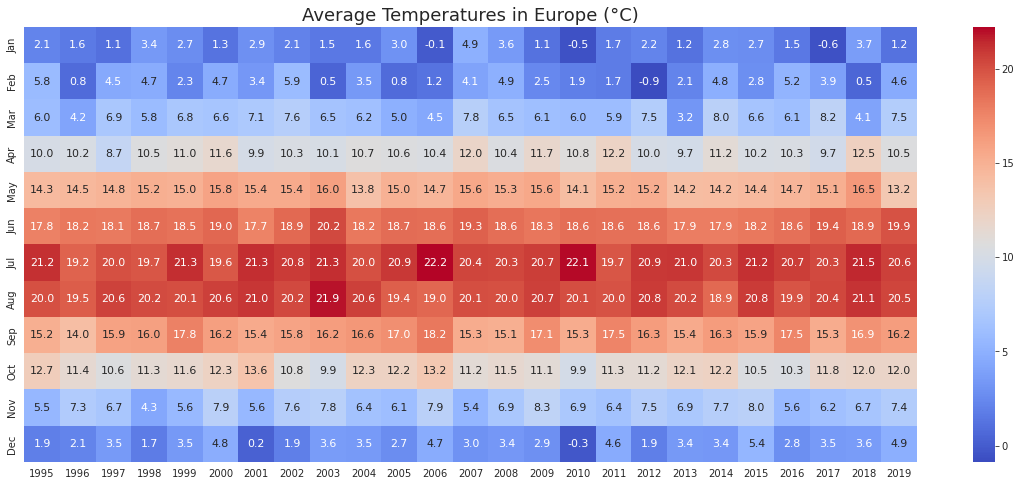

In [175]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(data = europe_pivoted, cmap='coolwarm', annot=True, fmt=".1f", annot_kws={'size':11})
plt.ylabel('')
plt.xlabel('')
plt.title('Average Temperatures in Europe (°C)', fontsize=18)
ax.set_yticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

### Austria

In [152]:
df_austria = df_europe[df_europe.Country == 'Austria'].copy()

In [153]:
df_austria.head()

,Region,Country,City,Month,Day,Year,Date,AvgTempCelsius,AvgTempCelsius_rounded,AvgTempCelsius_rounded2
632643,Europe,Austria,Vienna,1,1,1995,1995-01-01,2.048828,2.05,2.0
632644,Europe,Austria,Vienna,1,2,1995,1995-01-01,1.493164,1.49,1.5
632645,Europe,Austria,Vienna,1,3,1995,1995-01-01,-0.329834,-0.33,-0.3
632646,Europe,Austria,Vienna,1,4,1995,1995-01-01,-3.777344,-3.78,-3.8
632647,Europe,Austria,Vienna,1,5,1995,1995-01-01,-5.000000,-5.00,-5.0


#### DISTRIBUTION OF TEMPERATURES IN AUSTRIA

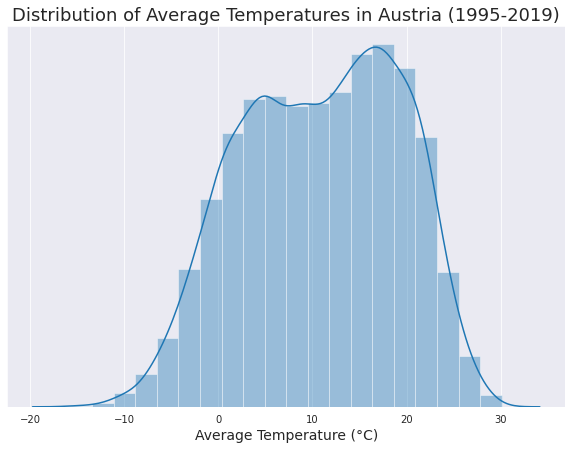

In [155]:
f, ax = plt.subplots(figsize=(10, 7))
sns.distplot(df_austria.AvgTempCelsius_rounded, bins=20);
plt.title('Distribution of Average Temperatures in Austria (1995-2019)', fontsize=18)
plt.xlabel('Average Temperature (°C)', fontsize=14)
ax.axes.yaxis.set_visible(False)
ax.axes.yaxis.set_ticklabels([''])
plt.plot()

#### YEARLY AVERAGE TEMPERATURE IN AUSTRIA OVER TIME

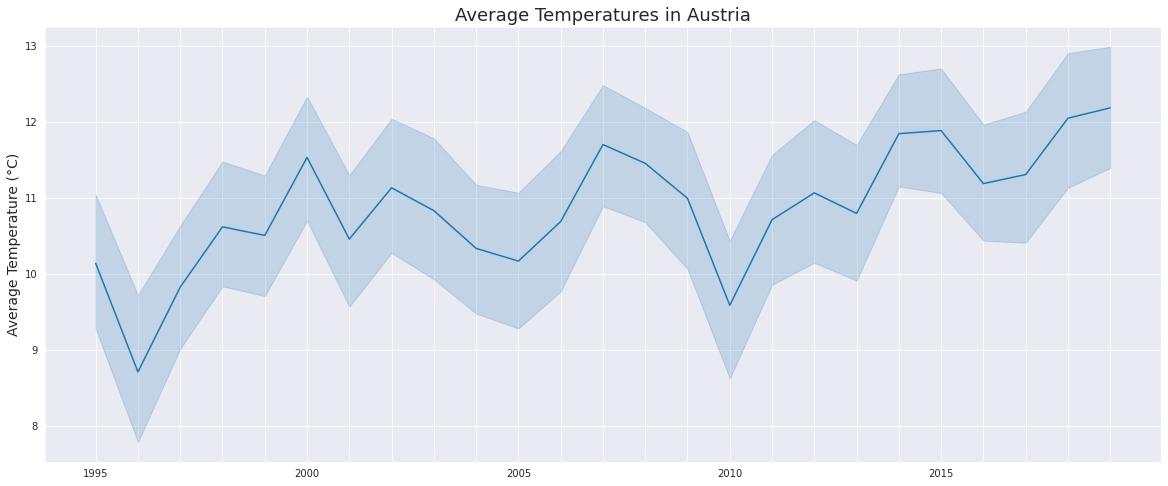

In [159]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x='Year', y='AvgTempCelsius_rounded2', data=df_austria)
plt.title('Average Temperatures in Austria', fontsize=18)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.xlabel('')
plt.xticks(range(1995, 2020))
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)
plt.show()

#### MONTHLY AVERAGE TEMPERATURE IN AUSTRIA

In [160]:
years = df_austria.Year.unique().tolist()
years = [str(year) for year in years]

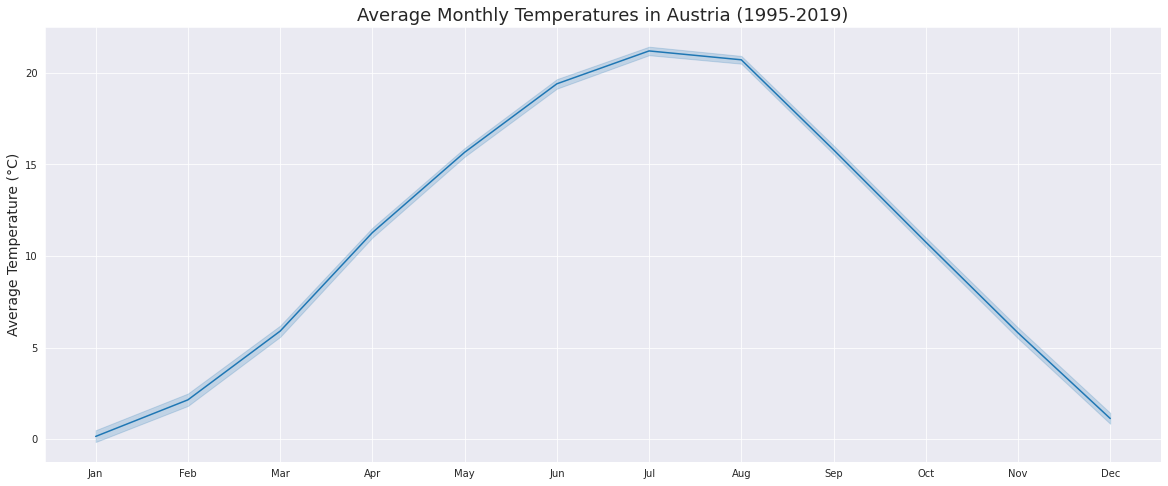

In [177]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x='Month', y='AvgTempCelsius_rounded2', data=df_austria)
plt.title('Average Monthly Temperatures in Austria (1995-2019)', fontsize=18)
plt.ylabel('Average Temperature (°C)', fontsize=14)
plt.xlabel('')
plt.xticks(range(1, 13))
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show();

#### MONTHLY AVERAGE TEMPERATURE IN AUSTRIA (DETAILED)

In [163]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

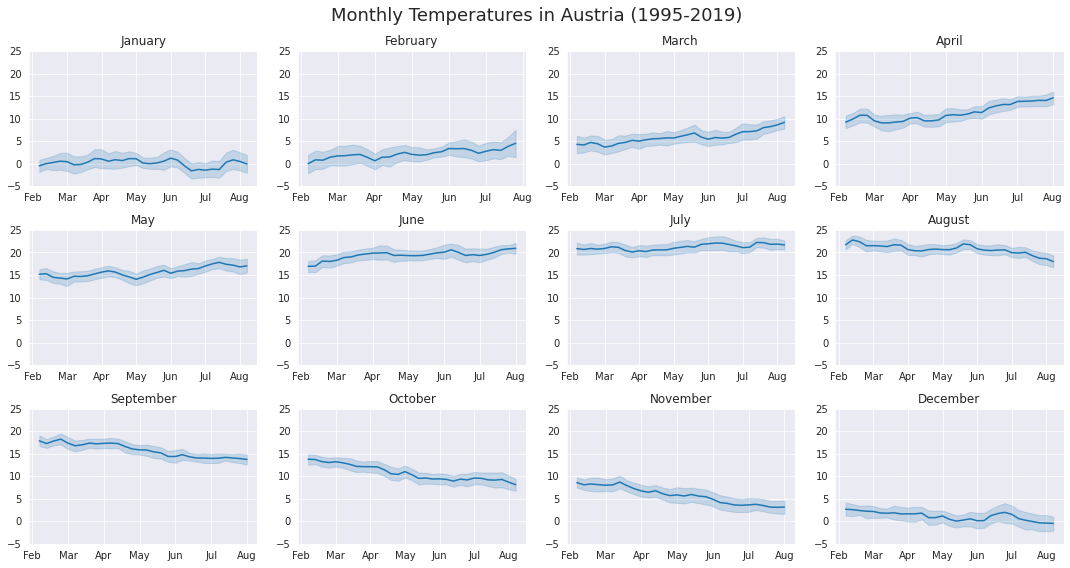

In [167]:
fig = plt.subplots(3,4, figsize = (15,8))
plt.suptitle('Monthly Temperatures in Austria (1995-2019)', fontsize=18)
for i in range(1,13): 
    ax = plt.subplot(3, 4, i)
    sns.lineplot(x='Day', y='AvgTempCelsius_rounded2', data=df_austria[df_austria.Month == i])
    ax.title.set_text(months[i-1])
    ax.set_ylim((-5,25))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.tight_layout()
plt.show()

#### MONTHLY AVERAGE TEMPERATURE IN AUSTRIA OVER TIME

In [168]:
austria_pivoted = pd.pivot_table(
    data=df_austria,
    index='Month',
    values='AvgTempCelsius_rounded2',
    columns='Year'
)

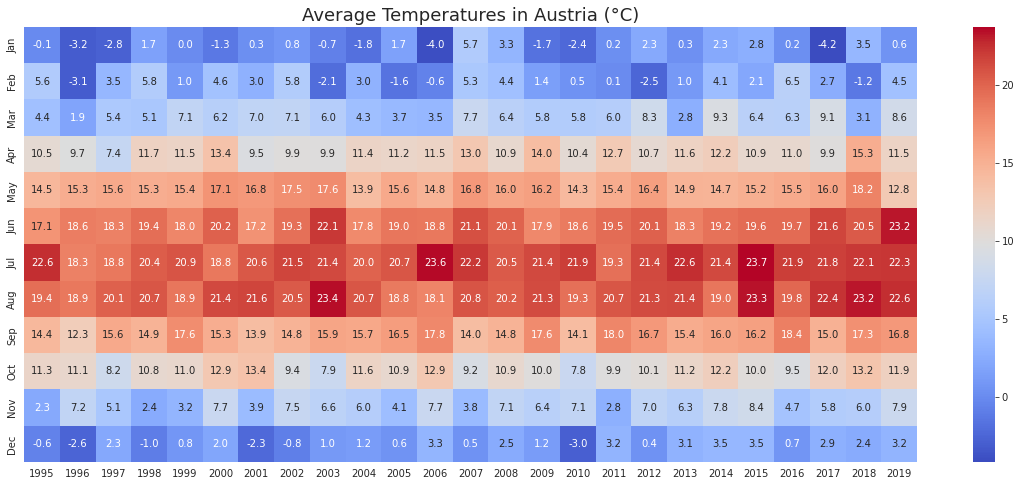

In [176]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(data=austria_pivoted, cmap='coolwarm', annot=True, fmt=".1f")
plt.ylabel('')
ax.set_yticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel('')
plt.title('Average Temperatures in Austria (°C)', fontsize=18)
plt.show()